# GSoC 2023 ML4SCI QML-HEP Tasks

Marçal Comajoan Cara

## Task I: Quantum Computing Part

### Task statement

1) Implement a the following simple quantum circuit:
    1. With 5 qubits.
    2. Apply Hadamard operation on every qubit.
    3. Apply CNOT operation on (0, 1), (1, 2), (2, 3), (3, 4).
    4. SWAP (0, 4).
    5. Rotate X with pi/2 on any qubit.
    6. Plot the circuit.
2) Implement a second circuit with a framework of your choice:
    1. Apply a Hadmard gate to the first qubit.
    2. Rotate the second qubit by pi/3 around X.
    3. Apply a Hadamard gate to the third and fourth qubit.
    4. Perform a swap test between the states of the first and second qubit |q1 q2> and the third and fourth qubit |q3 q4>.

---

### Introduction

I will solve the tasks both using Cirq [1][2] and PennyLane [3]:

In [1]:
import math

import cirq
from cirq.contrib.svg import SVGCircuit as plot_circuit

import pennylane as qml
from pennylane import numpy as np

### Subtask 1

#### Cirq

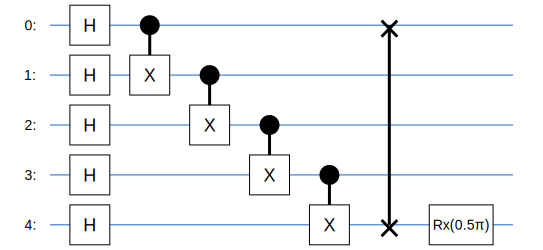

In [2]:
# Define the 5 qubits
qubits = cirq.LineQubit.range(5)

# Define the circuit
circuit1 = cirq.Circuit(
    # Hadamard on every qubit
    cirq.H.on_each(*qubits),
    
    # CNOT on (0, 1), (1, 2), (2, 3), (3, 4)
    cirq.CNOT(qubits[0], qubits[1]),
    cirq.CNOT(qubits[1], qubits[2]),
    cirq.CNOT(qubits[2], qubits[3]),
    cirq.CNOT(qubits[3], qubits[4]),
    
    # SWAP (0, 4)
    cirq.SWAP(qubits[0], qubits[4]),
    
    # Rotate the last qubit by pi/2 around X
    cirq.rx(math.pi / 2).on(qubits[4])
)

# Plot the circuit
plot_circuit(circuit1)

#### PennyLane

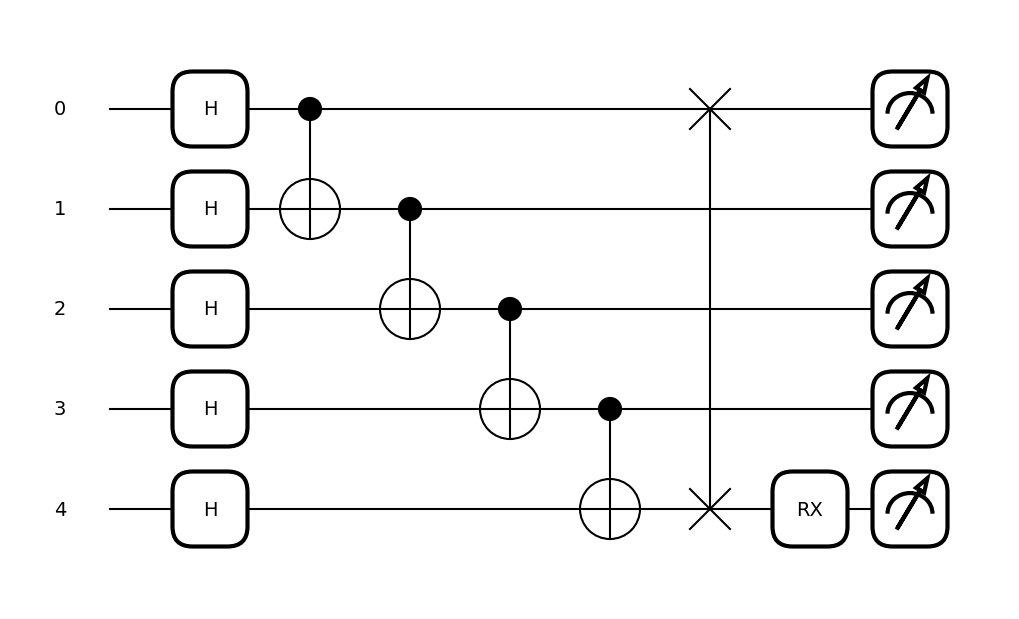

In [3]:
# Define the device and number of wires
dev = qml.device("default.qubit", wires=5)

# Define the circuit
@qml.qnode(dev)
def circuit1():
    # Hadamard on every qubit
    for i in range(dev.num_wires):
        qml.Hadamard(wires=i)
    
    # CNOT on (0, 1), (1, 2), (2, 3), (3, 4)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 4])
    
    # SWAP (0, 4)
    qml.SWAP(wires=[0, 4])
    
    # Rotate the last qubit by pi/2 around X
    qml.RX(np.pi/2, wires=4)
    
    # Circuits in PennyLane must return measurements
    return qml.probs()
    
qml.draw_mpl(circuit1)();

### Subtask 2

#### Cirq

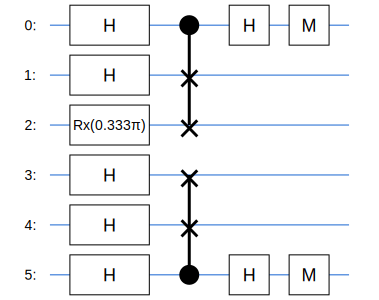

In [4]:
# Define the 6 qubits we will use
qubits = cirq.LineQubit.range(6)

# Define the circuit
circuit2 = cirq.Circuit(
    # Hadamard gate on q1
    cirq.H(qubits[1]),
    
    # q2 rotation by pi/3 around X
    cirq.rx(math.pi / 3).on(qubits[2]),
    
    # Hadamard gate on q3 and q4
    cirq.H(qubits[3]),
    cirq.H(qubits[4]),
    
    # Swap test between |q1 q2> using q0 as ancilla qubit
    cirq.H(qubits[0]),
    cirq.SWAP(qubits[1], qubits[2]).controlled_by(qubits[0]),
    cirq.H(qubits[0]),
    cirq.measure(qubits[0]),
    
    # Swap test between |q3 q4> using q5 as ancilla qubit
    cirq.H(qubits[5]),
    cirq.SWAP(qubits[3], qubits[4]).controlled_by(qubits[5]),
    cirq.H(qubits[5]),
    cirq.measure(qubits[5]),
)

# Plot the circuit
plot_circuit(circuit2)

##### Bonus: Simulation

Now let us simulate the circuit and see the results:

In [5]:
simulator = cirq.Simulator()
reps = 1_000_000
result = simulator.run(circuit2, repetitions=reps).data
dict(result['0'].value_counts() / reps), dict(result['5'].value_counts() / reps)

({0: 0.750342, 1: 0.249658}, {0: 1.0})

Recall that the swap test takes two input states. If they are orthogonal, then the probability that 0 is measured is 0.5, while if the states are equal, then the probability that 0 is measured is 1. [4]

Now, looking at the results, we can conclude that the states of the first and second qubits are neither orthogonal nor equal, and that the third and fourth qubits are equal. This makes sense if we look at the diagram.

#### PennyLane

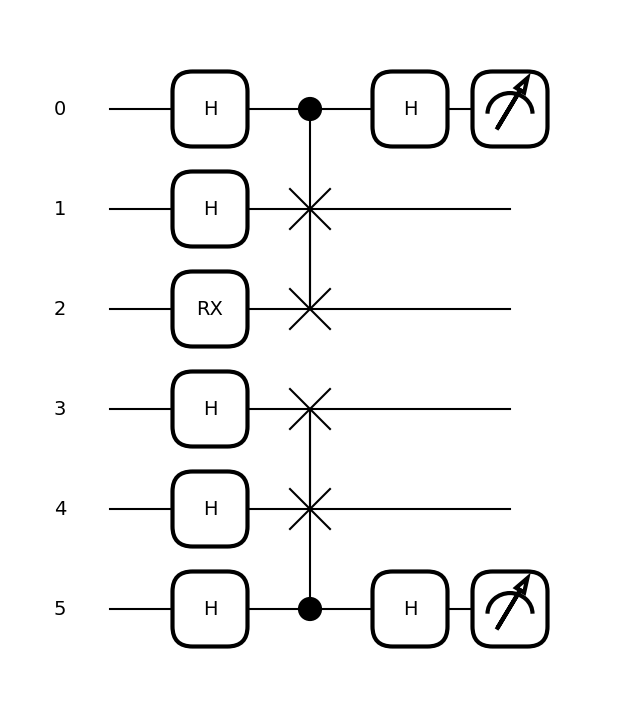

In [6]:
# Define the device and number of wires
dev = qml.device("default.qubit", wires=6)

# Define the circuit
@qml.qnode(dev)
def circuit2():
    # Hadamard gate on q1
    qml.Hadamard(wires=[1])
    
    # q2 rotation by pi/3 around X
    qml.RX(np.pi/3, wires=[2])
    
    # Hadamard gate on q3 and q4
    qml.Hadamard(wires=[3])
    qml.Hadamard(wires=[4])
    
    # Swap test between |q1 q2> using q0 as ancilla qubit
    qml.Hadamard(wires=[0])
    qml.CSWAP(wires=[0, 1, 2])
    qml.Hadamard(wires=[0])
    
    # Swap test between |q3 q4> using q5 as ancilla qubit
    qml.Hadamard(wires=[5])
    qml.CSWAP(wires=[5, 3, 4])
    qml.Hadamard(wires=[5])
    
    return qml.probs(wires=[0, 5])
    
# Plot the circuit
qml.draw_mpl(circuit2)();

Now let us see the probabilities:

In [7]:
circuit2()

tensor([0.75, 0.  , 0.25, 0.  ], requires_grad=True)

The returned array is in lexicographic order, so the probability of measuring $|00\rangle$ is 0.75 and the probability of measuring $|10\rangle$ is 0.25. These results coincide with the ones obtained with Cirq, as we can observe that we measure 0 on q5 with probability 1, showing that the states of q3 and q4 are equal, and 0 on q0 with probability 0.75, indicating that the states of q1 and q2 are neither orthogonal nor equal.

### References

1. [Cirq](https://quantumai.google/cirq)
1. [Hello, many worlds (TensorFlow Quantum)](https://www.tensorflow.org/quantum/tutorials/hello_many_worlds)
1. [PennyLane](https://pennylane.ai/)
1. [Swap test (Wikipedia)](https://en.wikipedia.org/wiki/Swap_test)
